# Explore parameter dependence of LTP-IE-induced spike sequences

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy as copy

import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln, analysis, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,
    'W_INH_PC': 0.003, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.00, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": 10},
}

# ANALYSIS
A_PARAMS = {
    'MIN_START': 0.25,  # s
    'SMOOTH_FR': 4,  # 2 ms
    'MIN_GAP_DUR': .01,  # s
    'MIN_EVT_DUR': .03,  # s
    'EVT_DTCN_TH': 0.5,  # Hz
    'SPEED_CALC_TRNC_FRAC': 0.1,  # fraction
    'POS_T_CORR_TH': 0.85,  # correlation
}

## Analysis function unit tests

In [2]:
def test_evt_processing():
    a_params = {'MIN_GAP_DUR': 0.25, 'MIN_EVT_DUR': 0.25}
    
    starts, ends = np.array([
        [0.1, 0.9, 1.2, 2.0, 3.6, 4.6, 6.9, 7.2, 9.5],
        [0.6, 1.1, 1.9, 2.8, 3.8, 5.7, 7.1, 8.4, 9.6],
    ])
    
    starts_desired = np.array([0.1, 0.9, 4.6, 6.9])
    ends_desired = np.array([0.6, 2.8, 5.7, 8.4])
    
    # remove short gaps and short events
    starts, ends = analysis.remove_short_gaps(starts, ends, a_params['MIN_GAP_DUR'])
    starts, ends = analysis.remove_short_evts(starts, ends, a_params['MIN_EVT_DUR'])
    
    print('Desired starts:', starts_desired)
    print('Actual  starts:', starts)
    print('Desired ends:', ends_desired)
    print('Actual  ends:', ends)
    
test_evt_processing()

Desired starts: [0.1 0.9 4.6 6.9]
Actual  starts: [0.1 0.9 4.6 6.9]
Desired ends: [0.6 2.8 5.7 8.4]
Actual  ends: [0.6 2.8 5.7 8.4]


## Analysis tests on example simulations

### Functional replay test

In [3]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 12
s_params['schedule']['D_SMLN'] = 5

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


Event 0
  fr_trj =  5.624280782508635 Hz
  fr_ntrj =  0.29854310962503006 Hz
  pos-t corr =  -0.8425217309591493
Event 1
  fr_trj =  4.7727272727272725 Hz
  fr_ntrj =  0.3129314312011045 Hz
  pos-t corr =  -0.9847885126021089
Event 2
  fr_trj =  4.97862286228623 Hz
  fr_ntrj =  0.37128712871287134 Hz
  pos-t corr =  0.9955732042821315
Event 3
  fr_trj =  5.519480519480511 Hz
  fr_ntrj =  0.2927781392322703 Hz
  pos-t corr =  -0.8431529997346395
Event 4
  fr_trj =  5.3345022929592645 Hz
  fr_ntrj =  0.3443256256648562 Hz
  pos-t corr =  -0.9671465152670812
Event 5
  fr_trj =  5.495251017639064 Hz
  fr_ntrj =  0.14080540692762566 Hz
  pos-t corr =  0.4988225684566823
Event 6
  fr_trj =  4.938811188811186 Hz
  fr_ntrj =  0.3220246734397675 Hz
  pos-t corr =  0.9565034030203645
Event 7
  fr_trj =  4.945543454100914 Hz
  fr_ntrj =  0.40134704986852443 Hz
  pos-t corr =  0.9755573816366879
Event 8
  fr_trj =  4.772727272727269 Hz
  fr_ntrj =  0.3679245283018865 Hz
  pos-t corr =  -0.94605507

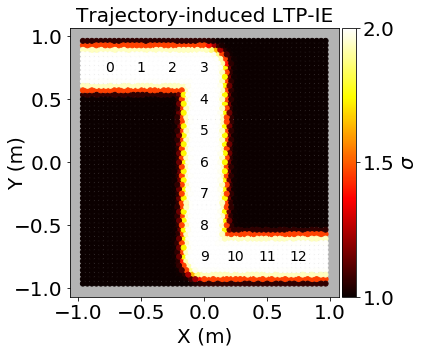

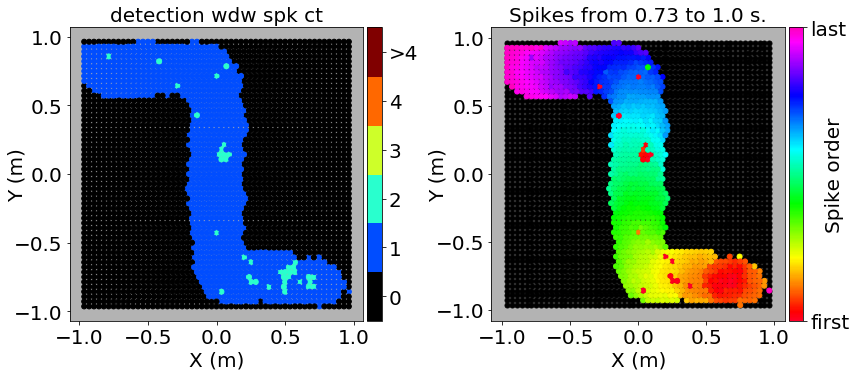

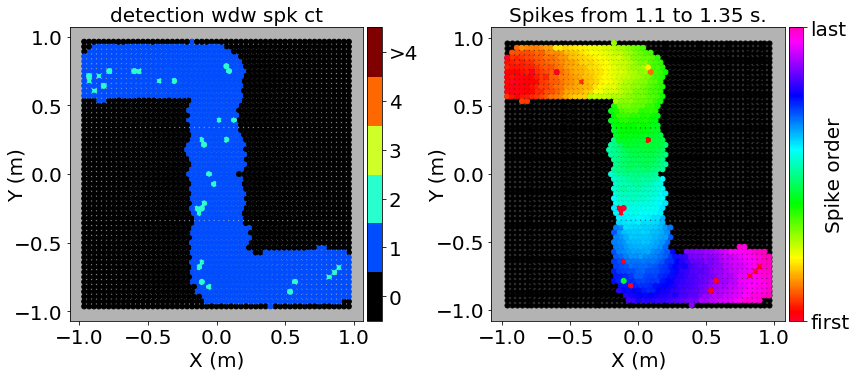

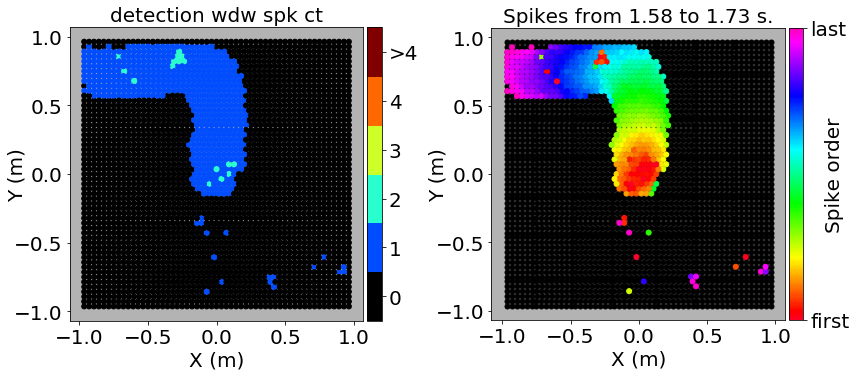

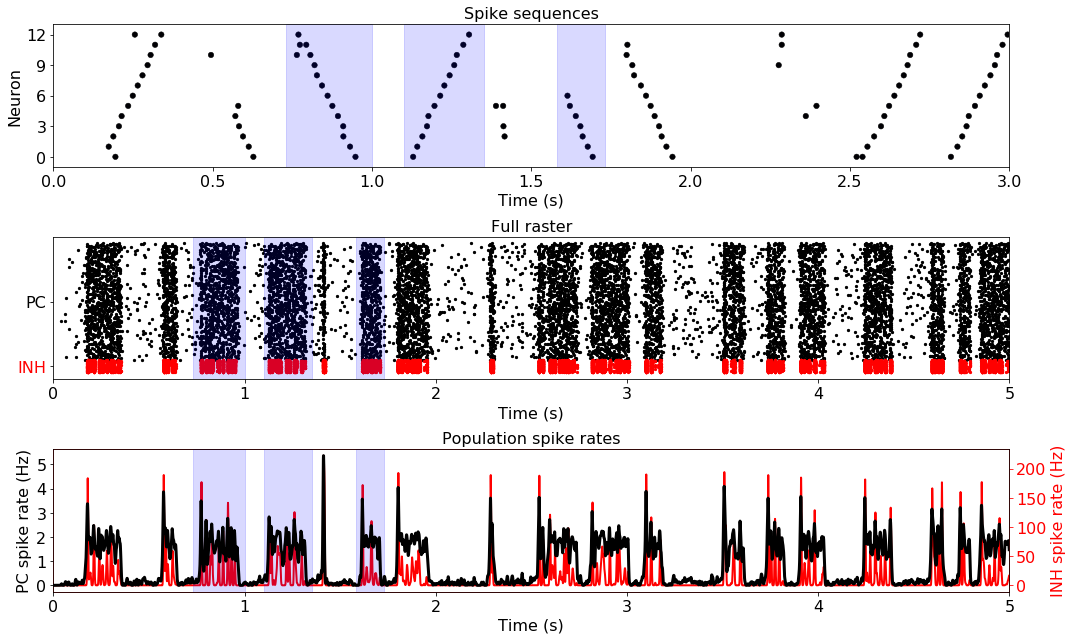

In [4]:
# get metrics
## candidate event boundaries
starts, ends = analysis.get_evts(rslt, A_PARAMS)

## event features
for e_ctr, (start, end) in enumerate(zip(starts, ends)):
    
    # trj-PC and non-trj-PC firing rates during candidate events
    fr_trj, fr_ntrj = analysis.get_fr_trj_ntrj(rslt, start, end, A_PARAMS)
    
    # pos-t rank correlation ("one-way-ness")
    pos_t_corr = analysis.get_pos_t_corr(rslt, start, end, A_PARAMS)
    
    print('Event', e_ctr)
    print('  fr_trj = ', fr_trj, 'Hz')
    print('  fr_ntrj = ', fr_ntrj, 'Hz')
    print('  pos-t corr = ', pos_t_corr)

## full get_metrics function
print(analysis.get_metrics(rslt, A_PARAMS))

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.73, 1.), (1.1, 1.35), (1.58, 1.73)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)

### Blowup test

In [5]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

m_params['W_PC_INH'] = 0
m_params['W_PC_PC'] = 0.03
s_params['RNG_SEED'] = 0
s_params['schedule']['D_SMLN'] = 1

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


Event 0
  fr_trj =  11.038961038961043 Hz
  fr_ntrj =  10.963093510263324 Hz
  pos-t corr =  0.596089505545441
Event 1
  fr_trj =  9.417087542087538 Hz
  fr_ntrj =  9.237421383647794 Hz
  pos-t corr =  0.8677441206388863
Event 2
  fr_trj =  12.333702882483372 Hz
  fr_ntrj =  12.166359871145886 Hz
  pos-t corr =  -0.6996925974158957
{'one_way_ct': 1, 'evt_dur': 0.09366666666666666, 'fr_ntrj': 10.788958255019002, 'evt_ct': 3, 'fr_trj': 10.929917154510653}


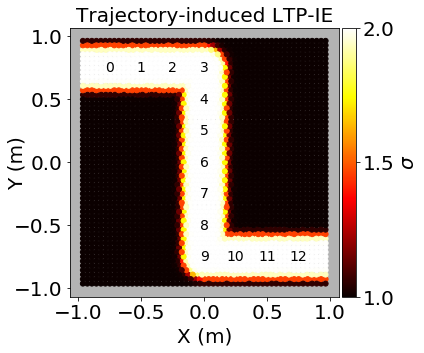

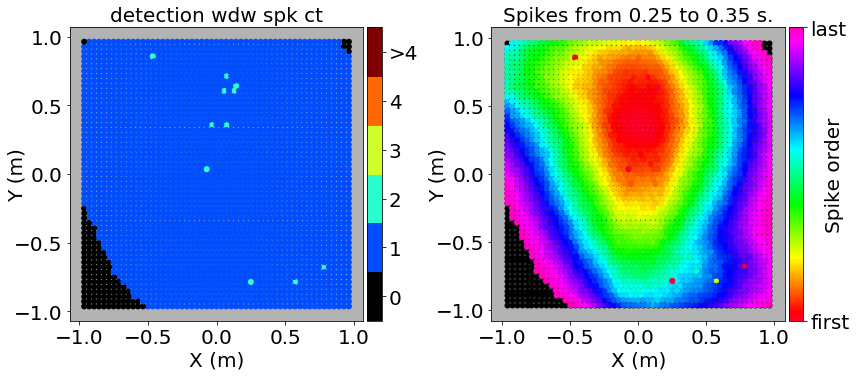

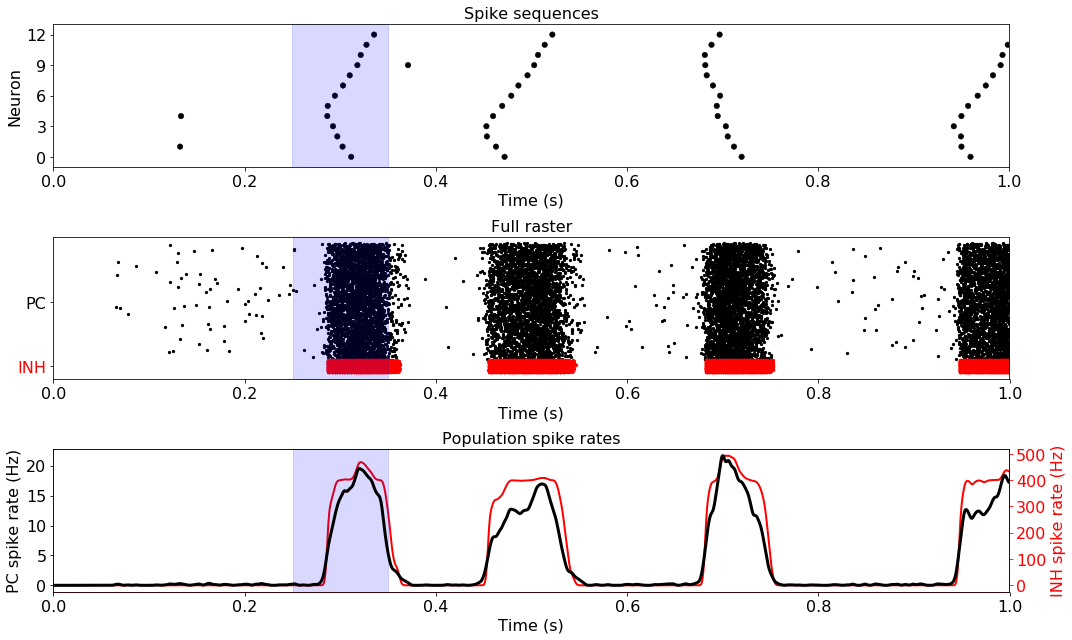

In [6]:
# get metrics
## candidate event boundaries
starts, ends = analysis.get_evts(rslt, A_PARAMS)

## event features
for e_ctr, (start, end) in enumerate(zip(starts, ends)):
    
    # trj-PC and non-trj-PC firing rates during candidate events
    fr_trj, fr_ntrj = analysis.get_fr_trj_ntrj(rslt, start, end, A_PARAMS)
    
    # pos-t rank correlation ("one-way-ness")
    pos_t_corr = analysis.get_pos_t_corr(rslt, start, end, A_PARAMS)
    
    print('Event', e_ctr)
    print('  fr_trj = ', fr_trj, 'Hz')
    print('  fr_ntrj = ', fr_ntrj, 'Hz')
    print('  pos-t corr = ', pos_t_corr)

## full get_metrics function
print(analysis.get_metrics(rslt, A_PARAMS))

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.25, .35)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 1),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)

### Fadeout test

In [7]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

m_params['W_PC_INH'] = 0
m_params['W_PC_PC'] = 0.01
s_params['RNG_SEED'] = 0
s_params['schedule']['D_SMLN'] = 1

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


{'one_way_ct': 0, 'evt_dur': -1, 'fr_ntrj': -1, 'evt_ct': 0, 'fr_trj': -1}


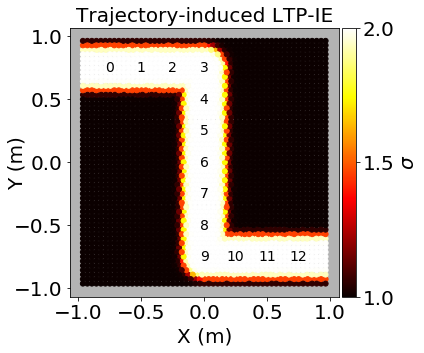

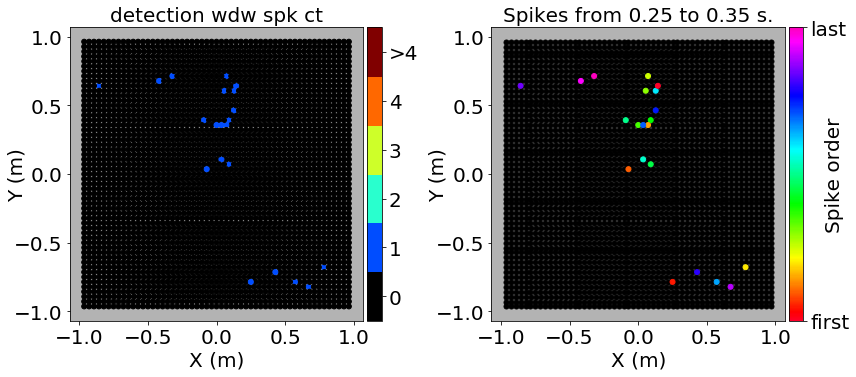

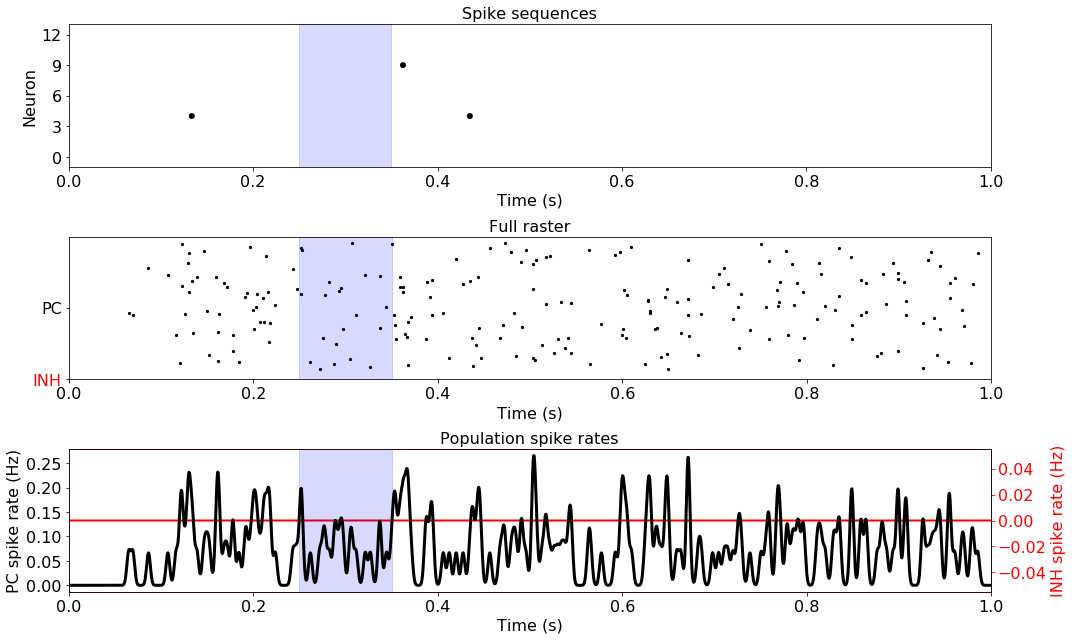

In [8]:
# get metrics
## candidate event boundaries
starts, ends = analysis.get_evts(rslt, A_PARAMS)

## event features
for e_ctr, (start, end) in enumerate(zip(starts, ends)):
    
    # trj-PC and non-trj-PC firing rates during candidate events
    fr_trj, fr_ntrj = analysis.get_fr_trj_ntrj(rslt, start, end, A_PARAMS)
    
    # pos-t rank correlation ("one-way-ness")
    pos_t_corr = analysis.get_pos_t_corr(rslt, start, end, A_PARAMS)
    
    print('Event', e_ctr)
    print('  fr_trj = ', fr_trj, 'Hz')
    print('  fr_ntrj = ', fr_ntrj, 'Hz')
    print('  pos-t corr = ', pos_t_corr)

## full get_metrics function
print(analysis.get_metrics(rslt, A_PARAMS))

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.25, .35)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 1),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)

# Run param sweeps

## 2D grid searches

### SWEEP 0: W_PC_PC vs L_PC_PC

In [4]:
import json
from sys import stdout

VARY = {'W_PC_PC': np.linspace(.02, .04, 21), 'L_PC_PC': np.linspace(.04, .066, 21)}
SAVE_FILE = 'PARAM_SWEEP_RESULTS_0_W_PC_PC_L_PC_PC.txt'
N_SMLNS = np.prod([len(v) for v in VARY.values()])

SWEEP_PARAMS = {
    'VARY': list(VARY.keys()),
    'N_TRIALS': 10,
    'SAVE_FILE': SAVE_FILE,
    'N_SMLNS': int(N_SMLNS),
}

# write file header
with open(SAVE_FILE, 'w') as f:
    header = {
        'SWEEP_PARAMS': SWEEP_PARAMS,
        'M_PARAMS': M_PARAMS,
        'S_PARAMS': S_PARAMS,
        'A_PARAMS': A_PARAMS,
    }
    f.write(json.dumps(header) + '\n\n')

# loop over params
param_0 = SWEEP_PARAMS['VARY'][0]
param_1 = SWEEP_PARAMS['VARY'][1]

## make params copy
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

## run loop
smln_id = 0
for param_val_0 in VARY[param_0]:
    for param_val_1 in VARY[param_1]:
        
        print('Running SMLN {}/{}: {} = {}, {} = {}'.format(
            smln_id, N_SMLNS, param_0, param_val_0, param_1, param_val_1))
        
        # set model params
        m_params[param_0] = param_val_0
        m_params[param_1] = param_val_1
        
        # loop over RNG SEEDS
        rng_seeds = np.arange(SWEEP_PARAMS['N_TRIALS'])
        metrics = {}
        
        for rng_seed in rng_seeds:
            stdout.write('.')
            
            # set RNG seed
            s_params['RNG_SEED'] = rng_seed
            rslt = smln.run(m_params, s_params)
            
            # calc metrics
            metrics[int(rng_seed)] = analysis.get_metrics(rslt, A_PARAMS)
            
        print('')
    
        save_dict = {'SMLN_ID': smln_id, 'PARAMS': {param_0: param_val_0, param_1: param_val_1}, 'METRICS': metrics}
        smln_id += 1

        # append results to save file
        with open(SAVE_FILE, 'a') as f:
            f.write(json.dumps(save_dict) + '\n')

Running SMLN 0/441: W_PC_PC = 0.02, L_PC_PC = 0.04
..........
Running SMLN 1/441: W_PC_PC = 0.02, L_PC_PC = 0.0413
..........
Running SMLN 2/441: W_PC_PC = 0.02, L_PC_PC = 0.0426
..........
Running SMLN 3/441: W_PC_PC = 0.02, L_PC_PC = 0.0439
..........
Running SMLN 4/441: W_PC_PC = 0.02, L_PC_PC = 0.045200000000000004
..........
Running SMLN 5/441: W_PC_PC = 0.02, L_PC_PC = 0.0465
..........
Running SMLN 6/441: W_PC_PC = 0.02, L_PC_PC = 0.0478
..........
Running SMLN 7/441: W_PC_PC = 0.02, L_PC_PC = 0.049100000000000005
..........
Running SMLN 8/441: W_PC_PC = 0.02, L_PC_PC = 0.0504
..........
Running SMLN 9/441: W_PC_PC = 0.02, L_PC_PC = 0.0517
..........
Running SMLN 10/441: W_PC_PC = 0.02, L_PC_PC = 0.053000000000000005
..........
Running SMLN 11/441: W_PC_PC = 0.02, L_PC_PC = 0.0543
..........
Running SMLN 12/441: W_PC_PC = 0.02, L_PC_PC = 0.055600000000000004
..........
Running SMLN 13/441: W_PC_PC = 0.02, L_PC_PC = 0.056900000000000006
..........
Running SMLN 14/441: W_PC_PC = 0

..........
Running SMLN 224/441: W_PC_PC = 0.03, L_PC_PC = 0.0582
..........
Running SMLN 225/441: W_PC_PC = 0.03, L_PC_PC = 0.059500000000000004
..........
Running SMLN 226/441: W_PC_PC = 0.03, L_PC_PC = 0.06080000000000001
..........
Running SMLN 227/441: W_PC_PC = 0.03, L_PC_PC = 0.0621
..........
Running SMLN 228/441: W_PC_PC = 0.03, L_PC_PC = 0.06340000000000001
..........
Running SMLN 229/441: W_PC_PC = 0.03, L_PC_PC = 0.06470000000000001
..........
Running SMLN 230/441: W_PC_PC = 0.03, L_PC_PC = 0.066
..........
Running SMLN 231/441: W_PC_PC = 0.031, L_PC_PC = 0.04
..........
Running SMLN 232/441: W_PC_PC = 0.031, L_PC_PC = 0.0413
..........
Running SMLN 233/441: W_PC_PC = 0.031, L_PC_PC = 0.0426
..........
Running SMLN 234/441: W_PC_PC = 0.031, L_PC_PC = 0.0439
..........
Running SMLN 235/441: W_PC_PC = 0.031, L_PC_PC = 0.045200000000000004
..........
Running SMLN 236/441: W_PC_PC = 0.031, L_PC_PC = 0.0465
..........
Running SMLN 237/441: W_PC_PC = 0.031, L_PC_PC = 0.0478
.....

..........
Running SMLN 337/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.0413
..........
Running SMLN 338/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.0426
..........
Running SMLN 339/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.0439
..........
Running SMLN 340/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.045200000000000004
..........
Running SMLN 341/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.0465
..........
Running SMLN 342/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.0478
..........
Running SMLN 343/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.049100000000000005
..........
Running SMLN 344/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.0504
..........
Running SMLN 345/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.0517
..........
Running SMLN 346/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.053000000000000005
..........
Running SMLN 347/441: W_PC_PC = 0.036000000000000004, L_PC_PC = 0.0543
..........
Running SMLN 348/441: W_PC_PC = 0.03600000000

### SWEEP 1: W_PC_PC vs W_PC_INH

In [4]:
import json
from sys import stdout

VARY = {'W_PC_PC': np.linspace(.02, .04, 21), 'W_PC_INH': np.linspace(0, .0006, 21)}
SAVE_FILE = 'PARAM_SWEEP_RESULTS_1_W_PC_PC_W_PC_INH.txt'
N_SMLNS = np.prod([len(v) for v in VARY.values()])

SWEEP_PARAMS = {
    'VARY': list(VARY.keys()),
    'N_TRIALS': 10,
    'SAVE_FILE': SAVE_FILE,
    'N_SMLNS': int(N_SMLNS),
}

# write file header
with open(SAVE_FILE, 'w') as f:
    header = {
        'SWEEP_PARAMS': SWEEP_PARAMS,
        'M_PARAMS': M_PARAMS,
        'S_PARAMS': S_PARAMS,
        'A_PARAMS': A_PARAMS,
    }
    f.write(json.dumps(header) + '\n\n')

# loop over params
param_0 = SWEEP_PARAMS['VARY'][0]
param_1 = SWEEP_PARAMS['VARY'][1]

## make params copy
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

## run loop
smln_id = 0
for param_val_0 in VARY[param_0]:
    for param_val_1 in VARY[param_1]:
        
        print('Running SMLN {}/{}: {} = {}, {} = {}'.format(
            smln_id, N_SMLNS, param_0, param_val_0, param_1, param_val_1))
        
        # set model params
        m_params[param_0] = param_val_0
        m_params[param_1] = param_val_1
        
        # loop over RNG SEEDS
        rng_seeds = np.arange(SWEEP_PARAMS['N_TRIALS'])
        metrics = {}
        
        for rng_seed in rng_seeds:
            stdout.write('.')
            
            # set RNG seed
            s_params['RNG_SEED'] = rng_seed
            rslt = smln.run(m_params, s_params)
            
            # calc metrics
            metrics[int(rng_seed)] = analysis.get_metrics(rslt, A_PARAMS)
            
        print('')
    
        save_dict = {'SMLN_ID': smln_id, 'PARAMS': {param_0: param_val_0, param_1: param_val_1}, 'METRICS': metrics}
        smln_id += 1

        # append results to save file
        with open(SAVE_FILE, 'a') as f:
            f.write(json.dumps(save_dict) + '\n')

Running SMLN 0/441: W_PC_INH = 0.0, W_PC_PC = 0.02
..........
Running SMLN 1/441: W_PC_INH = 0.0, W_PC_PC = 0.021
..........
Running SMLN 2/441: W_PC_INH = 0.0, W_PC_PC = 0.022
..........
Running SMLN 3/441: W_PC_INH = 0.0, W_PC_PC = 0.023
..........
Running SMLN 4/441: W_PC_INH = 0.0, W_PC_PC = 0.024
..........
Running SMLN 5/441: W_PC_INH = 0.0, W_PC_PC = 0.025
..........
Running SMLN 6/441: W_PC_INH = 0.0, W_PC_PC = 0.026000000000000002
..........
Running SMLN 7/441: W_PC_INH = 0.0, W_PC_PC = 0.027
..........
Running SMLN 8/441: W_PC_INH = 0.0, W_PC_PC = 0.028
..........
Running SMLN 9/441: W_PC_INH = 0.0, W_PC_PC = 0.029
..........
Running SMLN 10/441: W_PC_INH = 0.0, W_PC_PC = 0.03
..........
Running SMLN 11/441: W_PC_INH = 0.0, W_PC_PC = 0.031
..........
Running SMLN 12/441: W_PC_INH = 0.0, W_PC_PC = 0.032
..........
Running SMLN 13/441: W_PC_INH = 0.0, W_PC_PC = 0.033
..........
Running SMLN 14/441: W_PC_INH = 0.0, W_PC_PC = 0.034
..........
Running SMLN 15/441: W_PC_INH = 0.0, 

..........
Running SMLN 101/441: W_PC_INH = 0.00011999999999999999, W_PC_PC = 0.037000000000000005
..........
Running SMLN 102/441: W_PC_INH = 0.00011999999999999999, W_PC_PC = 0.038000000000000006
..........
Running SMLN 103/441: W_PC_INH = 0.00011999999999999999, W_PC_PC = 0.039
..........
Running SMLN 104/441: W_PC_INH = 0.00011999999999999999, W_PC_PC = 0.04
..........
Running SMLN 105/441: W_PC_INH = 0.00015, W_PC_PC = 0.02
..........
Running SMLN 106/441: W_PC_INH = 0.00015, W_PC_PC = 0.021
..........
Running SMLN 107/441: W_PC_INH = 0.00015, W_PC_PC = 0.022
..........
Running SMLN 108/441: W_PC_INH = 0.00015, W_PC_PC = 0.023
..........
Running SMLN 109/441: W_PC_INH = 0.00015, W_PC_PC = 0.024
..........
Running SMLN 110/441: W_PC_INH = 0.00015, W_PC_PC = 0.025
..........
Running SMLN 111/441: W_PC_INH = 0.00015, W_PC_PC = 0.026000000000000002
..........
Running SMLN 112/441: W_PC_INH = 0.00015, W_PC_PC = 0.027
..........
Running SMLN 113/441: W_PC_INH = 0.00015, W_PC_PC = 0.028


..........
Running SMLN 301/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.027
..........
Running SMLN 302/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.028
..........
Running SMLN 303/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.029
..........
Running SMLN 304/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.03
..........
Running SMLN 305/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.031
..........
Running SMLN 306/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.032
..........
Running SMLN 307/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.033
..........
Running SMLN 308/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.034
..........
Running SMLN 309/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.035
..........
Running SMLN 310/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.036000000000000004
..........
Running SMLN 311/441: W_PC_INH = 0.00041999999999999996, W_PC_PC = 0.037000000000000005
..........
Running SMLN 312/441: W_PC_INH = 0.0

..........
Running SMLN 400/441: W_PC_INH = 0.00057, W_PC_PC = 0.021
..........
Running SMLN 401/441: W_PC_INH = 0.00057, W_PC_PC = 0.022
..........
Running SMLN 402/441: W_PC_INH = 0.00057, W_PC_PC = 0.023
..........
Running SMLN 403/441: W_PC_INH = 0.00057, W_PC_PC = 0.024
..........
Running SMLN 404/441: W_PC_INH = 0.00057, W_PC_PC = 0.025
..........
Running SMLN 405/441: W_PC_INH = 0.00057, W_PC_PC = 0.026000000000000002
..........
Running SMLN 406/441: W_PC_INH = 0.00057, W_PC_PC = 0.027
..........
Running SMLN 407/441: W_PC_INH = 0.00057, W_PC_PC = 0.028
..........
Running SMLN 408/441: W_PC_INH = 0.00057, W_PC_PC = 0.029
..........
Running SMLN 409/441: W_PC_INH = 0.00057, W_PC_PC = 0.03
..........
Running SMLN 410/441: W_PC_INH = 0.00057, W_PC_PC = 0.031
..........
Running SMLN 411/441: W_PC_INH = 0.00057, W_PC_PC = 0.032
..........
Running SMLN 412/441: W_PC_INH = 0.00057, W_PC_PC = 0.033
..........
Running SMLN 413/441: W_PC_INH = 0.00057, W_PC_PC = 0.034
..........
Running S

### SWEEP 2: W_PC_PC vs SGM_MAX

In [4]:
import json
from sys import stdout

VARY = {'W_PC_PC': np.linspace(.02, .04, 21), 'SGM_MAX': np.linspace(1.2, 2.8, 21)}
SAVE_FILE = 'PARAM_SWEEP_RESULTS_2_W_PC_PC_SGM_MAX.txt'
N_SMLNS = np.prod([len(v) for v in VARY.values()])

SWEEP_PARAMS = {
    'VARY': list(VARY.keys()),
    'N_TRIALS': 10,
    'SAVE_FILE': SAVE_FILE,
    'N_SMLNS': int(N_SMLNS),
}

# write file header
with open(SAVE_FILE, 'w') as f:
    header = {
        'SWEEP_PARAMS': SWEEP_PARAMS,
        'M_PARAMS': M_PARAMS,
        'S_PARAMS': S_PARAMS,
        'A_PARAMS': A_PARAMS,
    }
    f.write(json.dumps(header) + '\n\n')

# loop over params
param_0 = SWEEP_PARAMS['VARY'][0]
param_1 = SWEEP_PARAMS['VARY'][1]

## make params copy
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

## run loop
smln_id = 0
for param_val_0 in VARY[param_0]:
    for param_val_1 in VARY[param_1]:
        
        print('Running SMLN {}/{}: {} = {}, {} = {}'.format(
            smln_id, N_SMLNS, param_0, param_val_0, param_1, param_val_1))
        
        # set model params
        m_params[param_0] = param_val_0
        m_params[param_1] = param_val_1
        
        # loop over RNG SEEDS
        rng_seeds = np.arange(SWEEP_PARAMS['N_TRIALS'])
        metrics = {}
        
        for rng_seed in rng_seeds:
            stdout.write('.')
            
            # set RNG seed
            s_params['RNG_SEED'] = rng_seed
            rslt = smln.run(m_params, s_params)
            
            # calc metrics
            metrics[int(rng_seed)] = analysis.get_metrics(rslt, A_PARAMS)
            
        print('')
    
        save_dict = {'SMLN_ID': smln_id, 'PARAMS': {param_0: param_val_0, param_1: param_val_1}, 'METRICS': metrics}
        smln_id += 1

        # append results to save file
        with open(SAVE_FILE, 'a') as f:
            f.write(json.dumps(save_dict) + '\n')

Running SMLN 0/441: W_PC_PC = 0.02, SGM_MAX = 1.2
..........
Running SMLN 1/441: W_PC_PC = 0.02, SGM_MAX = 1.28
..........
Running SMLN 2/441: W_PC_PC = 0.02, SGM_MAX = 1.3599999999999999
..........
Running SMLN 3/441: W_PC_PC = 0.02, SGM_MAX = 1.44
..........
Running SMLN 4/441: W_PC_PC = 0.02, SGM_MAX = 1.52
..........
Running SMLN 5/441: W_PC_PC = 0.02, SGM_MAX = 1.5999999999999999
..........
Running SMLN 6/441: W_PC_PC = 0.02, SGM_MAX = 1.68
..........
Running SMLN 7/441: W_PC_PC = 0.02, SGM_MAX = 1.7599999999999998
..........
Running SMLN 8/441: W_PC_PC = 0.02, SGM_MAX = 1.8399999999999999
..........
Running SMLN 9/441: W_PC_PC = 0.02, SGM_MAX = 1.92
..........
Running SMLN 10/441: W_PC_PC = 0.02, SGM_MAX = 1.9999999999999998
..........
Running SMLN 11/441: W_PC_PC = 0.02, SGM_MAX = 2.08
..........
Running SMLN 12/441: W_PC_PC = 0.02, SGM_MAX = 2.1599999999999997
..........
Running SMLN 13/441: W_PC_PC = 0.02, SGM_MAX = 2.2399999999999998
..........
Running SMLN 14/441: W_PC_PC = 

..........
Running SMLN 115/441: W_PC_PC = 0.025, SGM_MAX = 1.9999999999999998
..........
Running SMLN 116/441: W_PC_PC = 0.025, SGM_MAX = 2.08
..........
Running SMLN 117/441: W_PC_PC = 0.025, SGM_MAX = 2.1599999999999997
..........
Running SMLN 118/441: W_PC_PC = 0.025, SGM_MAX = 2.2399999999999998
..........
Running SMLN 119/441: W_PC_PC = 0.025, SGM_MAX = 2.32
..........
Running SMLN 120/441: W_PC_PC = 0.025, SGM_MAX = 2.3999999999999995
..........
Running SMLN 121/441: W_PC_PC = 0.025, SGM_MAX = 2.4799999999999995
..........
Running SMLN 122/441: W_PC_PC = 0.025, SGM_MAX = 2.5599999999999996
..........
Running SMLN 123/441: W_PC_PC = 0.025, SGM_MAX = 2.6399999999999997
..........
Running SMLN 124/441: W_PC_PC = 0.025, SGM_MAX = 2.7199999999999998
..........
Running SMLN 125/441: W_PC_PC = 0.025, SGM_MAX = 2.8
..........
Running SMLN 126/441: W_PC_PC = 0.026000000000000002, SGM_MAX = 1.2
..........
Running SMLN 127/441: W_PC_PC = 0.026000000000000002, SGM_MAX = 1.28
..........
Runn

..........
Running SMLN 224/441: W_PC_PC = 0.03, SGM_MAX = 2.32
..........
Running SMLN 225/441: W_PC_PC = 0.03, SGM_MAX = 2.3999999999999995
..........
Running SMLN 226/441: W_PC_PC = 0.03, SGM_MAX = 2.4799999999999995
..........
Running SMLN 227/441: W_PC_PC = 0.03, SGM_MAX = 2.5599999999999996
..........
Running SMLN 228/441: W_PC_PC = 0.03, SGM_MAX = 2.6399999999999997
..........
Running SMLN 229/441: W_PC_PC = 0.03, SGM_MAX = 2.7199999999999998
..........
Running SMLN 230/441: W_PC_PC = 0.03, SGM_MAX = 2.8
..........
Running SMLN 231/441: W_PC_PC = 0.031, SGM_MAX = 1.2
..........
Running SMLN 232/441: W_PC_PC = 0.031, SGM_MAX = 1.28
..........
Running SMLN 233/441: W_PC_PC = 0.031, SGM_MAX = 1.3599999999999999
..........
Running SMLN 234/441: W_PC_PC = 0.031, SGM_MAX = 1.44
..........
Running SMLN 235/441: W_PC_PC = 0.031, SGM_MAX = 1.52
..........
Running SMLN 236/441: W_PC_PC = 0.031, SGM_MAX = 1.5999999999999999
..........
Running SMLN 237/441: W_PC_PC = 0.031, SGM_MAX = 1.68
.

..........
Running SMLN 337/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.28
..........
Running SMLN 338/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.3599999999999999
..........
Running SMLN 339/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.44
..........
Running SMLN 340/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.52
..........
Running SMLN 341/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.5999999999999999
..........
Running SMLN 342/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.68
..........
Running SMLN 343/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.7599999999999998
..........
Running SMLN 344/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.8399999999999999
..........
Running SMLN 345/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.92
..........
Running SMLN 346/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 1.9999999999999998
..........
Running SMLN 347/441: W_PC_PC = 0.036000000000000004, SGM_MAX = 2.08
..........
Running SMLN 348/441: W_PC_PC = 0.03600

..........
Running SMLN 437/441: W_PC_PC = 0.04, SGM_MAX = 2.5599999999999996
..........
Running SMLN 438/441: W_PC_PC = 0.04, SGM_MAX = 2.6399999999999997
..........
Running SMLN 439/441: W_PC_PC = 0.04, SGM_MAX = 2.7199999999999998
..........
Running SMLN 440/441: W_PC_PC = 0.04, SGM_MAX = 2.8
..........


### SWEEP 3: L_PC_PC vs W_PC_INH

In [4]:
import json
from sys import stdout

VARY = {'L_PC_PC': np.linspace(.04, .066, 21), 'W_PC_INH': np.linspace(0, .0006, 21)}
SAVE_FILE = 'PARAM_SWEEP_RESULTS_3_L_PC_PC_W_PC_INH.txt'
N_SMLNS = np.prod([len(v) for v in VARY.values()])

SWEEP_PARAMS = {
    'VARY': list(VARY.keys()),
    'N_TRIALS': 10,
    'SAVE_FILE': SAVE_FILE,
    'N_SMLNS': int(N_SMLNS),
}

# write file header
with open(SAVE_FILE, 'w') as f:
    header = {
        'SWEEP_PARAMS': SWEEP_PARAMS,
        'M_PARAMS': M_PARAMS,
        'S_PARAMS': S_PARAMS,
        'A_PARAMS': A_PARAMS,
    }
    f.write(json.dumps(header) + '\n\n')

# loop over params
param_0 = SWEEP_PARAMS['VARY'][0]
param_1 = SWEEP_PARAMS['VARY'][1]

## make params copy
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

## run loop
smln_id = 0
for param_val_0 in VARY[param_0]:
    for param_val_1 in VARY[param_1]:
        
        print('Running SMLN {}/{}: {} = {}, {} = {}'.format(
            smln_id, N_SMLNS, param_0, param_val_0, param_1, param_val_1))
        
        # set model params
        m_params[param_0] = param_val_0
        m_params[param_1] = param_val_1
        
        # loop over RNG SEEDS
        rng_seeds = np.arange(SWEEP_PARAMS['N_TRIALS'])
        metrics = {}
        
        for rng_seed in rng_seeds:
            stdout.write('.')
            
            # set RNG seed
            s_params['RNG_SEED'] = rng_seed
            rslt = smln.run(m_params, s_params)
            
            # calc metrics
            metrics[int(rng_seed)] = analysis.get_metrics(rslt, A_PARAMS)
            
        print('')
    
        save_dict = {'SMLN_ID': smln_id, 'PARAMS': {param_0: param_val_0, param_1: param_val_1}, 'METRICS': metrics}
        smln_id += 1

        # append results to save file
        with open(SAVE_FILE, 'a') as f:
            f.write(json.dumps(save_dict) + '\n')

Running SMLN 0/441: W_PC_INH = 0.0, L_PC_PC = 0.04
..........
Running SMLN 1/441: W_PC_INH = 0.0, L_PC_PC = 0.0413
..........
Running SMLN 2/441: W_PC_INH = 0.0, L_PC_PC = 0.0426
..........
Running SMLN 3/441: W_PC_INH = 0.0, L_PC_PC = 0.0439
..........
Running SMLN 4/441: W_PC_INH = 0.0, L_PC_PC = 0.045200000000000004
..........
Running SMLN 5/441: W_PC_INH = 0.0, L_PC_PC = 0.0465
..........
Running SMLN 6/441: W_PC_INH = 0.0, L_PC_PC = 0.0478
..........
Running SMLN 7/441: W_PC_INH = 0.0, L_PC_PC = 0.049100000000000005
..........
Running SMLN 8/441: W_PC_INH = 0.0, L_PC_PC = 0.0504
..........
Running SMLN 9/441: W_PC_INH = 0.0, L_PC_PC = 0.0517
..........
Running SMLN 10/441: W_PC_INH = 0.0, L_PC_PC = 0.053000000000000005
..........
Running SMLN 11/441: W_PC_INH = 0.0, L_PC_PC = 0.0543
..........
Running SMLN 12/441: W_PC_INH = 0.0, L_PC_PC = 0.055600000000000004
..........
Running SMLN 13/441: W_PC_INH = 0.0, L_PC_PC = 0.056900000000000006
..........
Running SMLN 14/441: W_PC_INH = 

..........
Running SMLN 97/441: W_PC_INH = 0.00011999999999999999, L_PC_PC = 0.056900000000000006
..........
Running SMLN 98/441: W_PC_INH = 0.00011999999999999999, L_PC_PC = 0.0582
..........
Running SMLN 99/441: W_PC_INH = 0.00011999999999999999, L_PC_PC = 0.059500000000000004
..........
Running SMLN 100/441: W_PC_INH = 0.00011999999999999999, L_PC_PC = 0.06080000000000001
..........
Running SMLN 101/441: W_PC_INH = 0.00011999999999999999, L_PC_PC = 0.0621
..........
Running SMLN 102/441: W_PC_INH = 0.00011999999999999999, L_PC_PC = 0.06340000000000001
..........
Running SMLN 103/441: W_PC_INH = 0.00011999999999999999, L_PC_PC = 0.06470000000000001
..........
Running SMLN 104/441: W_PC_INH = 0.00011999999999999999, L_PC_PC = 0.066
..........
Running SMLN 105/441: W_PC_INH = 0.00015, L_PC_PC = 0.04
..........
Running SMLN 106/441: W_PC_INH = 0.00015, L_PC_PC = 0.0413
..........
Running SMLN 107/441: W_PC_INH = 0.00015, L_PC_PC = 0.0426
..........
Running SMLN 108/441: W_PC_INH = 0.000

..........
Running SMLN 191/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.0426
..........
Running SMLN 192/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.0439
..........
Running SMLN 193/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.045200000000000004
..........
Running SMLN 194/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.0465
..........
Running SMLN 195/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.0478
..........
Running SMLN 196/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.049100000000000005
..........
Running SMLN 197/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.0504
..........
Running SMLN 198/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.0517
..........
Running SMLN 199/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.053000000000000005
..........
Running SMLN 200/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.0543
..........
Running SMLN 201/441: W_PC_INH = 0.00026999999999999995, L_PC_PC = 0.055600000000000004
.........

..........
Running SMLN 289/441: W_PC_INH = 0.00038999999999999994, L_PC_PC = 0.06080000000000001
..........
Running SMLN 290/441: W_PC_INH = 0.00038999999999999994, L_PC_PC = 0.0621
..........
Running SMLN 291/441: W_PC_INH = 0.00038999999999999994, L_PC_PC = 0.06340000000000001
..........
Running SMLN 292/441: W_PC_INH = 0.00038999999999999994, L_PC_PC = 0.06470000000000001
..........
Running SMLN 293/441: W_PC_INH = 0.00038999999999999994, L_PC_PC = 0.066
..........
Running SMLN 294/441: W_PC_INH = 0.00041999999999999996, L_PC_PC = 0.04
..........
Running SMLN 295/441: W_PC_INH = 0.00041999999999999996, L_PC_PC = 0.0413
..........
Running SMLN 296/441: W_PC_INH = 0.00041999999999999996, L_PC_PC = 0.0426
..........
Running SMLN 297/441: W_PC_INH = 0.00041999999999999996, L_PC_PC = 0.0439
..........
Running SMLN 298/441: W_PC_INH = 0.00041999999999999996, L_PC_PC = 0.045200000000000004
..........
Running SMLN 299/441: W_PC_INH = 0.00041999999999999996, L_PC_PC = 0.0465
..........
Runn

..........
Running SMLN 384/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.0478
..........
Running SMLN 385/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.049100000000000005
..........
Running SMLN 386/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.0504
..........
Running SMLN 387/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.0517
..........
Running SMLN 388/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.053000000000000005
..........
Running SMLN 389/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.0543
..........
Running SMLN 390/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.055600000000000004
..........
Running SMLN 391/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.056900000000000006
..........
Running SMLN 392/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.0582
..........
Running SMLN 393/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.059500000000000004
..........
Running SMLN 394/441: W_PC_INH = 0.0005399999999999999, L_PC_PC = 0.06080000000

### SWEEP 4: R_G vs SGM_MAX

In [4]:
import json
from sys import stdout

VARY = {'R_G': np.linspace(75, 175, 21), 'SGM_MAX': np.linspace(1.2, 2.8, 21)}
SAVE_FILE = 'PARAM_SWEEP_RESULTS_4_R_G_SGM_MAX.txt'
N_SMLNS = np.prod([len(v) for v in VARY.values()])

SWEEP_PARAMS = {
    'VARY': list(VARY.keys()),
    'N_TRIALS': 10,
    'SAVE_FILE': SAVE_FILE,
    'N_SMLNS': int(N_SMLNS),
}

# write file header
with open(SAVE_FILE, 'w') as f:
    header = {
        'SWEEP_PARAMS': SWEEP_PARAMS,
        'M_PARAMS': M_PARAMS,
        'S_PARAMS': S_PARAMS,
        'A_PARAMS': A_PARAMS,
    }
    f.write(json.dumps(header) + '\n\n')

# loop over params
param_0 = SWEEP_PARAMS['VARY'][0]
param_1 = SWEEP_PARAMS['VARY'][1]

## make params copy
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

## run loop
smln_id = 0
for param_val_0 in VARY[param_0]:
    for param_val_1 in VARY[param_1]:
        
        print('Running SMLN {}/{}: {} = {}, {} = {}'.format(
            smln_id, N_SMLNS, param_0, param_val_0, param_1, param_val_1))
        
        # set model params
        m_params[param_0] = param_val_0
        m_params[param_1] = param_val_1
        
        # loop over RNG SEEDS
        rng_seeds = np.arange(SWEEP_PARAMS['N_TRIALS'])
        metrics = {}
        
        for rng_seed in rng_seeds:
            stdout.write('.')
            
            # set RNG seed
            s_params['RNG_SEED'] = rng_seed
            rslt = smln.run(m_params, s_params)
            
            # calc metrics
            metrics[int(rng_seed)] = analysis.get_metrics(rslt, A_PARAMS)
            
        print('')
    
        save_dict = {'SMLN_ID': smln_id, 'PARAMS': {param_0: param_val_0, param_1: param_val_1}, 'METRICS': metrics}
        smln_id += 1

        # append results to save file
        with open(SAVE_FILE, 'a') as f:
            f.write(json.dumps(save_dict) + '\n')

Running SMLN 0/441: SGM_MAX = 1.2, R_G = 75.0
..........
Running SMLN 1/441: SGM_MAX = 1.2, R_G = 80.0
..........
Running SMLN 2/441: SGM_MAX = 1.2, R_G = 85.0
..........
Running SMLN 3/441: SGM_MAX = 1.2, R_G = 90.0
..........
Running SMLN 4/441: SGM_MAX = 1.2, R_G = 95.0
..........
Running SMLN 5/441: SGM_MAX = 1.2, R_G = 100.0
..........
Running SMLN 6/441: SGM_MAX = 1.2, R_G = 105.0
..........
Running SMLN 7/441: SGM_MAX = 1.2, R_G = 110.0
..........
Running SMLN 8/441: SGM_MAX = 1.2, R_G = 115.0
..........
Running SMLN 9/441: SGM_MAX = 1.2, R_G = 120.0
..........
Running SMLN 10/441: SGM_MAX = 1.2, R_G = 125.0
..........
Running SMLN 11/441: SGM_MAX = 1.2, R_G = 130.0
..........
Running SMLN 12/441: SGM_MAX = 1.2, R_G = 135.0
..........
Running SMLN 13/441: SGM_MAX = 1.2, R_G = 140.0
..........
Running SMLN 14/441: SGM_MAX = 1.2, R_G = 145.0
..........
Running SMLN 15/441: SGM_MAX = 1.2, R_G = 150.0
..........
Running SMLN 16/441: SGM_MAX = 1.2, R_G = 155.0
..........
Running SMLN

..........
Running SMLN 128/441: SGM_MAX = 1.68, R_G = 85.0
..........
Running SMLN 129/441: SGM_MAX = 1.68, R_G = 90.0
..........
Running SMLN 130/441: SGM_MAX = 1.68, R_G = 95.0
..........
Running SMLN 131/441: SGM_MAX = 1.68, R_G = 100.0
..........
Running SMLN 132/441: SGM_MAX = 1.68, R_G = 105.0
..........
Running SMLN 133/441: SGM_MAX = 1.68, R_G = 110.0
..........
Running SMLN 134/441: SGM_MAX = 1.68, R_G = 115.0
..........
Running SMLN 135/441: SGM_MAX = 1.68, R_G = 120.0
..........
Running SMLN 136/441: SGM_MAX = 1.68, R_G = 125.0
..........
Running SMLN 137/441: SGM_MAX = 1.68, R_G = 130.0
..........
Running SMLN 138/441: SGM_MAX = 1.68, R_G = 135.0
..........
Running SMLN 139/441: SGM_MAX = 1.68, R_G = 140.0
..........
Running SMLN 140/441: SGM_MAX = 1.68, R_G = 145.0
..........
Running SMLN 141/441: SGM_MAX = 1.68, R_G = 150.0
..........
Running SMLN 142/441: SGM_MAX = 1.68, R_G = 155.0
..........
Running SMLN 143/441: SGM_MAX = 1.68, R_G = 160.0
..........
Running SMLN 144

..........
Running SMLN 249/441: SGM_MAX = 2.08, R_G = 165.0
..........
Running SMLN 250/441: SGM_MAX = 2.08, R_G = 170.0
..........
Running SMLN 251/441: SGM_MAX = 2.08, R_G = 175.0
..........
Running SMLN 252/441: SGM_MAX = 2.1599999999999997, R_G = 75.0
..........
Running SMLN 253/441: SGM_MAX = 2.1599999999999997, R_G = 80.0
..........
Running SMLN 254/441: SGM_MAX = 2.1599999999999997, R_G = 85.0
..........
Running SMLN 255/441: SGM_MAX = 2.1599999999999997, R_G = 90.0
..........
Running SMLN 256/441: SGM_MAX = 2.1599999999999997, R_G = 95.0
..........
Running SMLN 257/441: SGM_MAX = 2.1599999999999997, R_G = 100.0
..........
Running SMLN 258/441: SGM_MAX = 2.1599999999999997, R_G = 105.0
..........
Running SMLN 259/441: SGM_MAX = 2.1599999999999997, R_G = 110.0
..........
Running SMLN 260/441: SGM_MAX = 2.1599999999999997, R_G = 115.0
..........
Running SMLN 261/441: SGM_MAX = 2.1599999999999997, R_G = 120.0
..........
Running SMLN 262/441: SGM_MAX = 2.1599999999999997, R_G = 125

### SWEEP 5: R_G vs W_PC_INH

In [4]:
import json
from sys import stdout

VARY = {'R_G': np.linspace(75, 175, 21), 'W_PC_INH': np.linspace(0, .0006, 21)}
SAVE_FILE = 'PARAM_SWEEP_RESULTS_5_R_G_W_PC_INH.txt'
N_SMLNS = np.prod([len(v) for v in VARY.values()])

SWEEP_PARAMS = {
    'VARY': list(VARY.keys()),
    'N_TRIALS': 10,
    'SAVE_FILE': SAVE_FILE,
    'N_SMLNS': int(N_SMLNS),
}

# write file header
with open(SAVE_FILE, 'w') as f:
    header = {
        'SWEEP_PARAMS': SWEEP_PARAMS,
        'M_PARAMS': M_PARAMS,
        'S_PARAMS': S_PARAMS,
        'A_PARAMS': A_PARAMS,
    }
    f.write(json.dumps(header) + '\n\n')

# loop over params
param_0 = SWEEP_PARAMS['VARY'][0]
param_1 = SWEEP_PARAMS['VARY'][1]

## make params copy
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

## run loop
smln_id = 0
for param_val_0 in VARY[param_0]:
    for param_val_1 in VARY[param_1]:
        
        print('Running SMLN {}/{}: {} = {}, {} = {}'.format(
            smln_id, N_SMLNS, param_0, param_val_0, param_1, param_val_1))
        
        # set model params
        m_params[param_0] = param_val_0
        m_params[param_1] = param_val_1
        
        # loop over RNG SEEDS
        rng_seeds = np.arange(SWEEP_PARAMS['N_TRIALS'])
        metrics = {}
        
        for rng_seed in rng_seeds:
            stdout.write('.')
            
            # set RNG seed
            s_params['RNG_SEED'] = rng_seed
            rslt = smln.run(m_params, s_params)
            
            # calc metrics
            metrics[int(rng_seed)] = analysis.get_metrics(rslt, A_PARAMS)
            
        print('')
    
        save_dict = {'SMLN_ID': smln_id, 'PARAMS': {param_0: param_val_0, param_1: param_val_1}, 'METRICS': metrics}
        smln_id += 1

        # append results to save file
        with open(SAVE_FILE, 'a') as f:
            f.write(json.dumps(save_dict) + '\n')

Running SMLN 0/441: R_G = 75.0, W_PC_INH = 0.0
..........
Running SMLN 1/441: R_G = 75.0, W_PC_INH = 2.9999999999999997e-05
..........
Running SMLN 2/441: R_G = 75.0, W_PC_INH = 5.9999999999999995e-05
..........
Running SMLN 3/441: R_G = 75.0, W_PC_INH = 8.999999999999999e-05
..........
Running SMLN 4/441: R_G = 75.0, W_PC_INH = 0.00011999999999999999
..........
Running SMLN 5/441: R_G = 75.0, W_PC_INH = 0.00015
..........
Running SMLN 6/441: R_G = 75.0, W_PC_INH = 0.00017999999999999998
..........
Running SMLN 7/441: R_G = 75.0, W_PC_INH = 0.00020999999999999998
..........
Running SMLN 8/441: R_G = 75.0, W_PC_INH = 0.00023999999999999998
..........
Running SMLN 9/441: R_G = 75.0, W_PC_INH = 0.00026999999999999995
..........
Running SMLN 10/441: R_G = 75.0, W_PC_INH = 0.0003
..........
Running SMLN 11/441: R_G = 75.0, W_PC_INH = 0.00033
..........
Running SMLN 12/441: R_G = 75.0, W_PC_INH = 0.00035999999999999997
..........
Running SMLN 13/441: R_G = 75.0, W_PC_INH = 0.0003899999999999

..........
Running SMLN 113/441: R_G = 100.0, W_PC_INH = 0.00023999999999999998
..........
Running SMLN 114/441: R_G = 100.0, W_PC_INH = 0.00026999999999999995
..........
Running SMLN 115/441: R_G = 100.0, W_PC_INH = 0.0003
..........
Running SMLN 116/441: R_G = 100.0, W_PC_INH = 0.00033
..........
Running SMLN 117/441: R_G = 100.0, W_PC_INH = 0.00035999999999999997
..........
Running SMLN 118/441: R_G = 100.0, W_PC_INH = 0.00038999999999999994
..........
Running SMLN 119/441: R_G = 100.0, W_PC_INH = 0.00041999999999999996
..........
Running SMLN 120/441: R_G = 100.0, W_PC_INH = 0.00045
..........
Running SMLN 121/441: R_G = 100.0, W_PC_INH = 0.00047999999999999996
..........
Running SMLN 122/441: R_G = 100.0, W_PC_INH = 0.0005099999999999999
..........
Running SMLN 123/441: R_G = 100.0, W_PC_INH = 0.0005399999999999999
..........
Running SMLN 124/441: R_G = 100.0, W_PC_INH = 0.00057
..........
Running SMLN 125/441: R_G = 100.0, W_PC_INH = 0.0006
..........
Running SMLN 126/441: R_G = 

..........
Running SMLN 223/441: R_G = 125.0, W_PC_INH = 0.00038999999999999994
..........
Running SMLN 224/441: R_G = 125.0, W_PC_INH = 0.00041999999999999996
..........
Running SMLN 225/441: R_G = 125.0, W_PC_INH = 0.00045
..........
Running SMLN 226/441: R_G = 125.0, W_PC_INH = 0.00047999999999999996
..........
Running SMLN 227/441: R_G = 125.0, W_PC_INH = 0.0005099999999999999
..........
Running SMLN 228/441: R_G = 125.0, W_PC_INH = 0.0005399999999999999
..........
Running SMLN 229/441: R_G = 125.0, W_PC_INH = 0.00057
..........
Running SMLN 230/441: R_G = 125.0, W_PC_INH = 0.0006
..........
Running SMLN 231/441: R_G = 130.0, W_PC_INH = 0.0
..........
Running SMLN 232/441: R_G = 130.0, W_PC_INH = 2.9999999999999997e-05
..........
Running SMLN 233/441: R_G = 130.0, W_PC_INH = 5.9999999999999995e-05
..........
Running SMLN 234/441: R_G = 130.0, W_PC_INH = 8.999999999999999e-05
..........
Running SMLN 235/441: R_G = 130.0, W_PC_INH = 0.00011999999999999999
..........
Running SMLN 236/

..........
Running SMLN 333/441: R_G = 150.0, W_PC_INH = 0.0005399999999999999
..........
Running SMLN 334/441: R_G = 150.0, W_PC_INH = 0.00057
..........
Running SMLN 335/441: R_G = 150.0, W_PC_INH = 0.0006
..........
Running SMLN 336/441: R_G = 155.0, W_PC_INH = 0.0
..........
Running SMLN 337/441: R_G = 155.0, W_PC_INH = 2.9999999999999997e-05
..........
Running SMLN 338/441: R_G = 155.0, W_PC_INH = 5.9999999999999995e-05
..........
Running SMLN 339/441: R_G = 155.0, W_PC_INH = 8.999999999999999e-05
..........
Running SMLN 340/441: R_G = 155.0, W_PC_INH = 0.00011999999999999999
..........
Running SMLN 341/441: R_G = 155.0, W_PC_INH = 0.00015
..........
Running SMLN 342/441: R_G = 155.0, W_PC_INH = 0.00017999999999999998
..........
Running SMLN 343/441: R_G = 155.0, W_PC_INH = 0.00020999999999999998
..........
Running SMLN 344/441: R_G = 155.0, W_PC_INH = 0.00023999999999999998
..........
Running SMLN 345/441: R_G = 155.0, W_PC_INH = 0.00026999999999999995
..........
Running SMLN 346

## Random param sampling

In [ ]:
### PASTE IN LATER